## Imports

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Used to build and deploy machine learning apps
import tensorflow as tf

# Deep Learning API for creating Neural Networks (Runs on TensorFlow)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow import math
from keras.utils.vis_utils import plot_model

# Scikit-learn : machine learning library
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Check that there is a GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)


## Multi-class Classification

When you have more than 2 classes it is called a multi-class classification. Build neural network to classify written numbers from 0 to 9. We'll use the Tensorflow MNIST handwritten digit database. 60,000 training examples and a test set of 10,000. 28x28 grayscale image associated with 10 classes. 

## Download Data and check if the folders exist

In [4]:
# If using Jupyter, you can create the folders directly in the notebook
import os

# Root dataset directory
data_dir =  r'C:\Users\gyuugyuu\Documents\ACIT4830\bommo\data'

# Ensure the main folder and subfolders exist
os.makedirs(os.path.join(data_dir, 'american_football'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'baseball'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'basketball'), exist_ok=True)
#os.makedirs(os.path.join(data_dir, 'billiard_ball'), exist_ok=True)
#os.makedirs(os.path.join(data_dir, 'bowling_ball'), exist_ok=True)
#os.makedirs(os.path.join(data_dir, 'cricket_ball'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'football'), exist_ok=True)

##  Remove dodgy images

In [5]:
import cv2
import imghdr

# Path to the folder containing the pictures
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Split into Training & Test

In [6]:
# Load data and split into train/test
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,          # Number of images per batch
    shuffle=True            # Shuffle data
)

# Split into training and testing datasets
# Note: Adjust the split ratio as needed
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # Remaining for testing

train_data = data.take(train_size)
test_data = data.skip(train_size)

"""
# Inspect the first image and label in the training dataset
for images, labels in train_data.take(1):
    plt.imshow(images[0].numpy().astype(int))
    plt.title(f"Label: {labels[0]}")
    plt.show()
"""
# Helper function to separate images and labels
def extract_images_and_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset.as_numpy_iterator():
        images.extend(image_batch)  # Append images from the batch
        labels.extend(label_batch)  # Append labels from the batch
    return np.array(images), np.array(labels)

# Extract training and testing data
X_train, y_train = extract_images_and_labels(train_data)
X_test, y_test = extract_images_and_labels(test_data)

# Check the shape of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Found 618 files belonging to 4 classes.
X_train shape: (512, 256, 256, 3)
y_train shape: (512,)
X_test shape: (106, 256, 256, 3)
y_test shape: (106,)


In [25]:
y_train

array([1, 1, 0, 1, 3, 1, 0, 1, 2, 0, 0, 1, 2, 3, 0, 3, 2, 2, 3, 1, 3, 0,
       2, 0, 1, 3, 2, 0, 3, 1, 0, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 3, 3, 2, 1, 3, 2, 0, 3, 0, 2, 3,
       2, 2, 3, 2, 1, 1, 2, 0, 0, 0, 1, 1, 3, 2, 3, 3, 0, 2, 1, 3, 3, 3,
       3, 1, 3, 2, 3, 3, 1, 0, 0, 1, 0, 3, 2, 0, 1, 1, 2, 0, 0, 2, 2, 1,
       0, 0, 3, 1, 3, 2, 0, 1, 2, 0, 2, 3, 1, 3, 3, 3, 2, 0, 2, 2, 0, 3,
       0, 1, 2, 2, 1, 1, 1, 2, 3, 1, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 0, 3,
       2, 2, 3, 0, 1, 0, 1, 0, 3, 0, 0, 1, 1, 3, 1, 2, 3, 3, 2, 3, 3, 2,
       3, 2, 2, 0, 1, 3, 1, 1, 2, 1, 1, 1, 0, 0, 0, 3, 2, 1, 2, 1, 1, 2,
       2, 0, 3, 0, 1, 2, 1, 0, 0, 2, 0, 1, 0, 2, 3, 0, 2, 3, 2, 3, 0, 1,
       1, 0, 3, 2, 0, 3, 2, 0, 3, 1, 0, 0, 3, 0, 0, 3, 1, 3, 2, 0, 1, 2,
       0, 1, 0, 3, 2, 0, 2, 3, 3, 3, 3, 0, 0, 3, 3, 0, 2, 2, 1, 0, 0, 3,
       2, 1, 1, 0, 1, 3, 1, 0, 2, 0, 3, 0, 1, 2, 3, 3, 3, 1, 0, 0, 1, 1,
       1, 0, 0, 2, 0, 0, 3, 1, 3, 2, 0, 3, 1, 2, 3,

## Data Augumentation
Librarie:
https://github.com/mdbloice/Augmentor

In [8]:
#load images into a new directory

import cv2
import os
import numpy as np

# Path to the directory where you want to save the renamed images
save_dir = r'C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1'
os.makedirs(save_dir, exist_ok=True)

# Counter for total images processed and successfully saved
total_images = 0
saved_images = 0

# Iterate through each image in X_train and save it to the appropriate folder
for i in range(len(X_train)):
    # Get the class label for the current image
    class_label = y_train[i]
    # Construct the directory path for the current class
    class_dir = os.path.join(save_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)
    # Construct the new filename
    new_filename = f"image_{i}.jpg"
    # Save the image with the new filename in the appropriate class directory
    try:
        cv2.imwrite(os.path.join(class_dir, new_filename), cv2.cvtColor(X_train[i], cv2.COLOR_RGB2BGR))
        saved_images += 1
    except Exception as e:
        print(f"Error saving image {i}: {e}")
    total_images += 1

print(f"Total images processed: {total_images}")
print(f"Total images saved successfully: {saved_images}")


Total images processed: 512
Total images saved successfully: 512


In [9]:
# data augumentation into a new directory

import os
import cv2
import Augmentor

# Path to the new directory where augmented images will be saved
output_dir = r'C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1_edited'
os.makedirs(output_dir, exist_ok=True)

# Function to perform data augmentation on images in the input directory
def perform_augmentation(save_dir, output_dir):
    for class_name in os.listdir(save_dir):
        class_dir = os.path.join(save_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        p = Augmentor.Pipeline(class_dir, output_directory=output_class_dir)
        # Add your augmentation operations here
        p.zoom(probability=0.5, min_factor=0.8, max_factor=1.5)
        p.flip_top_bottom(probability=0.4)
        p.random_brightness(probability=0.3, min_factor=0.3, max_factor=1.2)
        p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
        
        # Sample 300 augmented images for each class
        p.sample(300)

# Perform data augmentation on images in the input directory and save to the output directory
perform_augmentation(save_dir, output_dir)


Initialised with 138 image(s) found.
Output directory set to C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1_edited\0.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x1C6489F2530>: 100%|██████████| 300/300 [00:01<00:00, 159.35 Samples/s]


Initialised with 126 image(s) found.
Output directory set to C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1_edited\1.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x1C64894AFB0>: 100%|██████████| 300/300 [00:01<00:00, 185.02 Samples/s]


Initialised with 126 image(s) found.
Output directory set to C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1_edited\2.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x1C64892B790>: 100%|██████████| 300/300 [00:01<00:00, 189.25 Samples/s]


Initialised with 122 image(s) found.
Output directory set to C:\Users\gyuugyuu\Documents\ACIT4830\bommo\dataAugumentation1_edited\3.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x1C648994700>: 100%|██████████| 300/300 [00:01<00:00, 187.90 Samples/s]


# below i need to split the data from dataAugmentation_edited into x_train and y_train.

In [ ]:
# Load data and split into train/test
data_augmented = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,          # Number of images per batch
    shuffle=True            # Shuffle data
)

# Split into training and testing datasets
# Note: Adjust the split ratio as needed
train_size = int(0.8 * len(data_augmented))  # 80% for training
test_size = len(data_augmented) - train_size  # Remaining for testing

train_data = data_augmented.take(train_size)
test_data = data_augmented.skip(train_size)

"""
# Inspect the first image and label in the training dataset
for images, labels in train_data.take(1):
    plt.imshow(images[0].numpy().astype(int))
    plt.title(f"Label: {labels[0]}")
    plt.show()
"""
# Helper function to separate images and labels
def extract_images_and_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset.as_numpy_iterator():
        images.extend(image_batch)  # Append images from the batch
        labels.extend(label_batch)  # Append labels from the batch
    return np.array(images), np.array(labels)

# Extract training and testing data
X_train, y_train = extract_images_and_labels(train_data)

# Check the shape of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# do not code from here

In [10]:
import os
import numpy as np
import cv2

# Function to load images from a directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

# Path to the directory containing the augmented images
augmented_dir = output_dir

# Load augmented images from the directory and resize them to match the original images
augmented_images_resized = []
for class_name in os.listdir(augmented_dir):
    class_dir = os.path.join(augmented_dir, class_name)
    class_images = load_images_from_dir(class_dir)
    resized_images = [cv2.resize(image, (256, 256)) for image in class_images]
    augmented_images_resized.extend(resized_images)

# Convert the list of resized augmented images into a numpy array
X_train_augmented = np.array(augmented_images_resized)


In [11]:
# Function to preprocess images
def preprocess_images(images, image_size=(256, 256)):
    processed_images = []
    for img in images:
        # Resize image to desired size (e.g., 256x256)
        img = cv2.resize(img, image_size)
        # Convert image to RGB color space (if not already)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Normalize pixel values to range [0, 1]
        img = img / 255.0
        processed_images.append(img)
    return np.array(processed_images)

# Preprocess augmented images
X_train_augmented = preprocess_images(X_train_augmented)

# Check the shape of the processed data
print("X_train_augumented processed shape:", X_train_augmented.shape)

X_train_augumented processed shape: (1200, 256, 256, 3)


In [12]:
# Check the shape of X_train after augmentation
print("X_augmented shape after augmentation:", X_train_augmented.shape)
print("X_train shape after augmentation:", X_train.shape)


X_augmented shape after augmentation: (1200, 256, 256, 3)
X_train shape after augmentation: (512, 256, 256, 3)


In [13]:
X_train_augmented

array([[[[0.98039216, 0.98039216, 0.98039216],
         [0.96470588, 0.96470588, 0.96470588],
         [0.94117647, 0.94117647, 0.94117647],
         ...,
         [0.96078431, 0.96078431, 0.96078431],
         [0.97254902, 0.97254902, 0.97254902],
         [0.98431373, 0.98431373, 0.98431373]],

        [[0.98431373, 0.98431373, 0.98431373],
         [0.98039216, 0.98039216, 0.98039216],
         [0.96862745, 0.96862745, 0.96862745],
         ...,
         [0.93333333, 0.93333333, 0.93333333],
         [0.93333333, 0.93333333, 0.93333333],
         [0.93333333, 0.93333333, 0.93333333]],

        [[0.98039216, 0.98039216, 0.98039216],
         [0.98823529, 0.98823529, 0.98823529],
         [0.99215686, 0.99215686, 0.99215686],
         ...,
         [0.90588235, 0.90588235, 0.90588235],
         [0.89019608, 0.89019608, 0.89019608],
         [0.88627451, 0.88627451, 0.88627451]],

        ...,

        [[0.98039216, 0.98039216, 0.98039216],
         [0.99215686, 0.99215686, 0.99215686]

In [16]:
np.amax(X_train_augmented)

1.0

In [17]:
np.amin(X_train_augmented)

0.0

## View Image

In [18]:

print(np.unique(y_test))

[0 1 2 3]


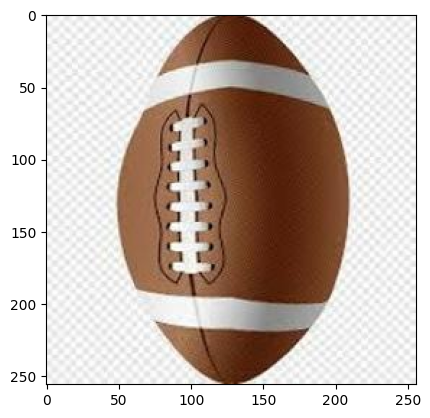

In [19]:
plt.imshow(X_train_augmented[0])
plt.show()

## Normalize the Features

In [15]:
# Before normalizing
#X_train

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

In [20]:
#X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [13]:
# After normalizing
#X_train

array([[[[7.1127094e-02, 8.0977648e-02, 8.6443752e-02],
         [7.5892292e-02, 8.3816983e-02, 8.7927543e-02],
         [7.7790350e-02, 8.4963717e-02, 8.9636549e-02],
         ...,
         [7.3338561e-02, 8.0255628e-02, 8.4768087e-02],
         [7.2688349e-02, 7.9157978e-02, 8.3400488e-02],
         [7.1847245e-02, 7.7852473e-02, 8.1840098e-02]],

        [[7.1127094e-02, 8.0977648e-02, 8.6443752e-02],
         [7.5892292e-02, 8.3816983e-02, 8.7927543e-02],
         [7.7790350e-02, 8.4963717e-02, 8.9636549e-02],
         ...,
         [7.3338561e-02, 8.0255628e-02, 8.4768087e-02],
         [7.2688349e-02, 7.9157978e-02, 8.3400488e-02],
         [7.1847245e-02, 7.7852473e-02, 8.1840098e-02]],

        [[7.1127094e-02, 8.0977648e-02, 8.6443752e-02],
         [7.5892292e-02, 8.3816983e-02, 8.7927543e-02],
         [7.7790350e-02, 8.4963717e-02, 8.9636549e-02],
         ...,
         [7.3338561e-02, 8.0255628e-02, 8.4768087e-02],
         [7.2688349e-02, 7.9157978e-02, 8.3400488e-02],
  

## Show Unique values in Label Numpy Array

In [21]:
len(X_train_augmented)

1200

In [22]:
np.unique(y_test)

array([0, 1, 2, 3])

## Store Label Names

In [23]:
label_names = np.unique(y_test)

## Build Model

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # High dropout in fully connected layers
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer
])


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(X_train_augmented, 
                      y_train,
                      epochs=25,
                      validation_data=(X_test, y_test))


ValueError: Data cardinality is ambiguous:
  x sizes: 1200
  y sizes: 512
Make sure all arrays contain the same number of samples.

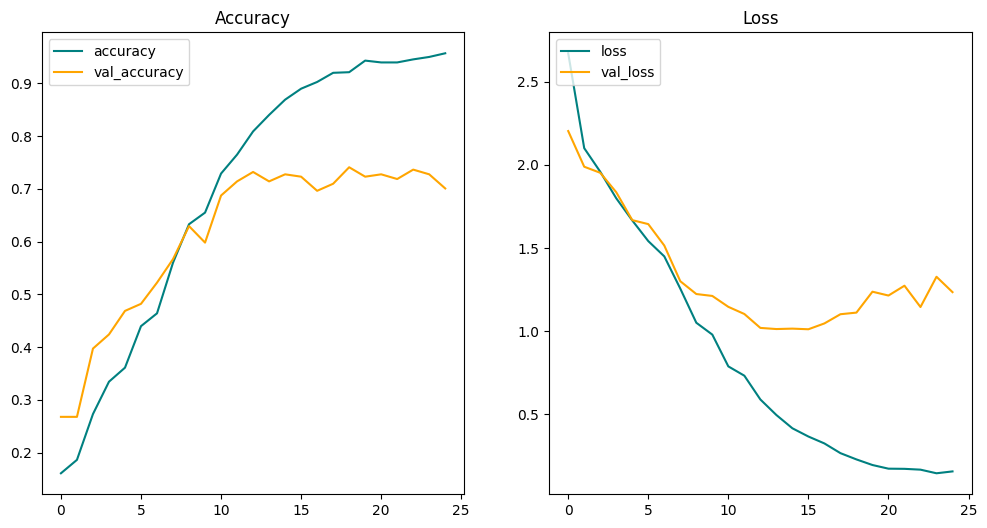

In [ ]:

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot loss on the first subplot
ax1.plot(history.history['accuracy'], color='teal', label='accuracy')
ax1.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
ax1.set_title('Accuracy')  # Set title for the first subplot
ax1.legend(loc='upper left')  # Add a legend

# Plot accuracy on the second subplot
ax2.plot(history.history['loss'], color='teal', label='loss')
ax2.plot(history.history['val_loss'], color='orange', label='val_loss')
ax2.set_title('Loss')  # Set title for the second subplot
ax2.legend(loc='upper left')  # Add a legend

# Show all plots
plt.show()  # Display the plots


## Learning rate
To see if it has a positive impact on the model

In [ ]:
#0.0005011872336272723
optimal_lr = 0.0015848931924611134
learning_rate=optimal_lr

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # High dropout in fully connected layers
    tf.keras.layers.Dense(16, activation='softmax')  # Output layer
])


model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=optimal_lr),
              metrics=["accuracy"])

# Learning rate callback
#scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
history_lr = model_2.fit(X_train, 
                              y_train,
                              epochs=25,
                              validation_data=(X_test, y_test))

Epoch 1/25
27/27 [==============================] - 60s 2s/step - loss: 2.6472 - accuracy: 0.1678 - val_loss: 2.0765 - val_accuracy: 0.2455
Epoch 2/25
27/27 [==============================] - 63s 2s/step - loss: 2.0600 - accuracy: 0.1748 - val_loss: 1.9585 - val_accuracy: 0.3170
Epoch 3/25
 2/27 [=>............................] - ETA: 56s - loss: 1.8968 - accuracy: 0.2812

## Find Ideal learning Rate

In [ ]:
"""
# The ideal learning rate is where the loss decreases the most
# Set random seed
tf.random.set_seed(66)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), 
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(10, activation="softmax") 
])

# Compile the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# Learning rate callback
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

# Fit the model
history_lr = model_4.fit(X_train, 
                              y_train,
                              epochs=40,
                              validation_data=(X_test, y_test),
                              callbacks=[scheduler])"""

'\n# The ideal learning rate is where the loss decreases the most\n# Set random seed\ntf.random.set_seed(66)\n\n# Create the model\nmodel_4 = tf.keras.Sequential([\n  tf.keras.layers.Flatten(input_shape=(28, 28)), \n  tf.keras.layers.Dense(4, activation="relu"),\n  tf.keras.layers.Dense(4, activation="relu"),\n  tf.keras.layers.Dense(10, activation="softmax") \n])\n\n# Compile the model\nmodel_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), \n                 optimizer=tf.keras.optimizers.Adam(),\n                 metrics=["accuracy"])\n\n# Learning rate callback\nscheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))\n\n# Fit the model\nhistory_lr = model_4.fit(X_train, \n                              y_train,\n                              epochs=40,\n                              validation_data=(X_test, y_test),\n                              callbacks=[scheduler])'

## Plot to Find Ideal Learning rate

Text(0.5, 1.0, 'Learning Rate vs. Loss')

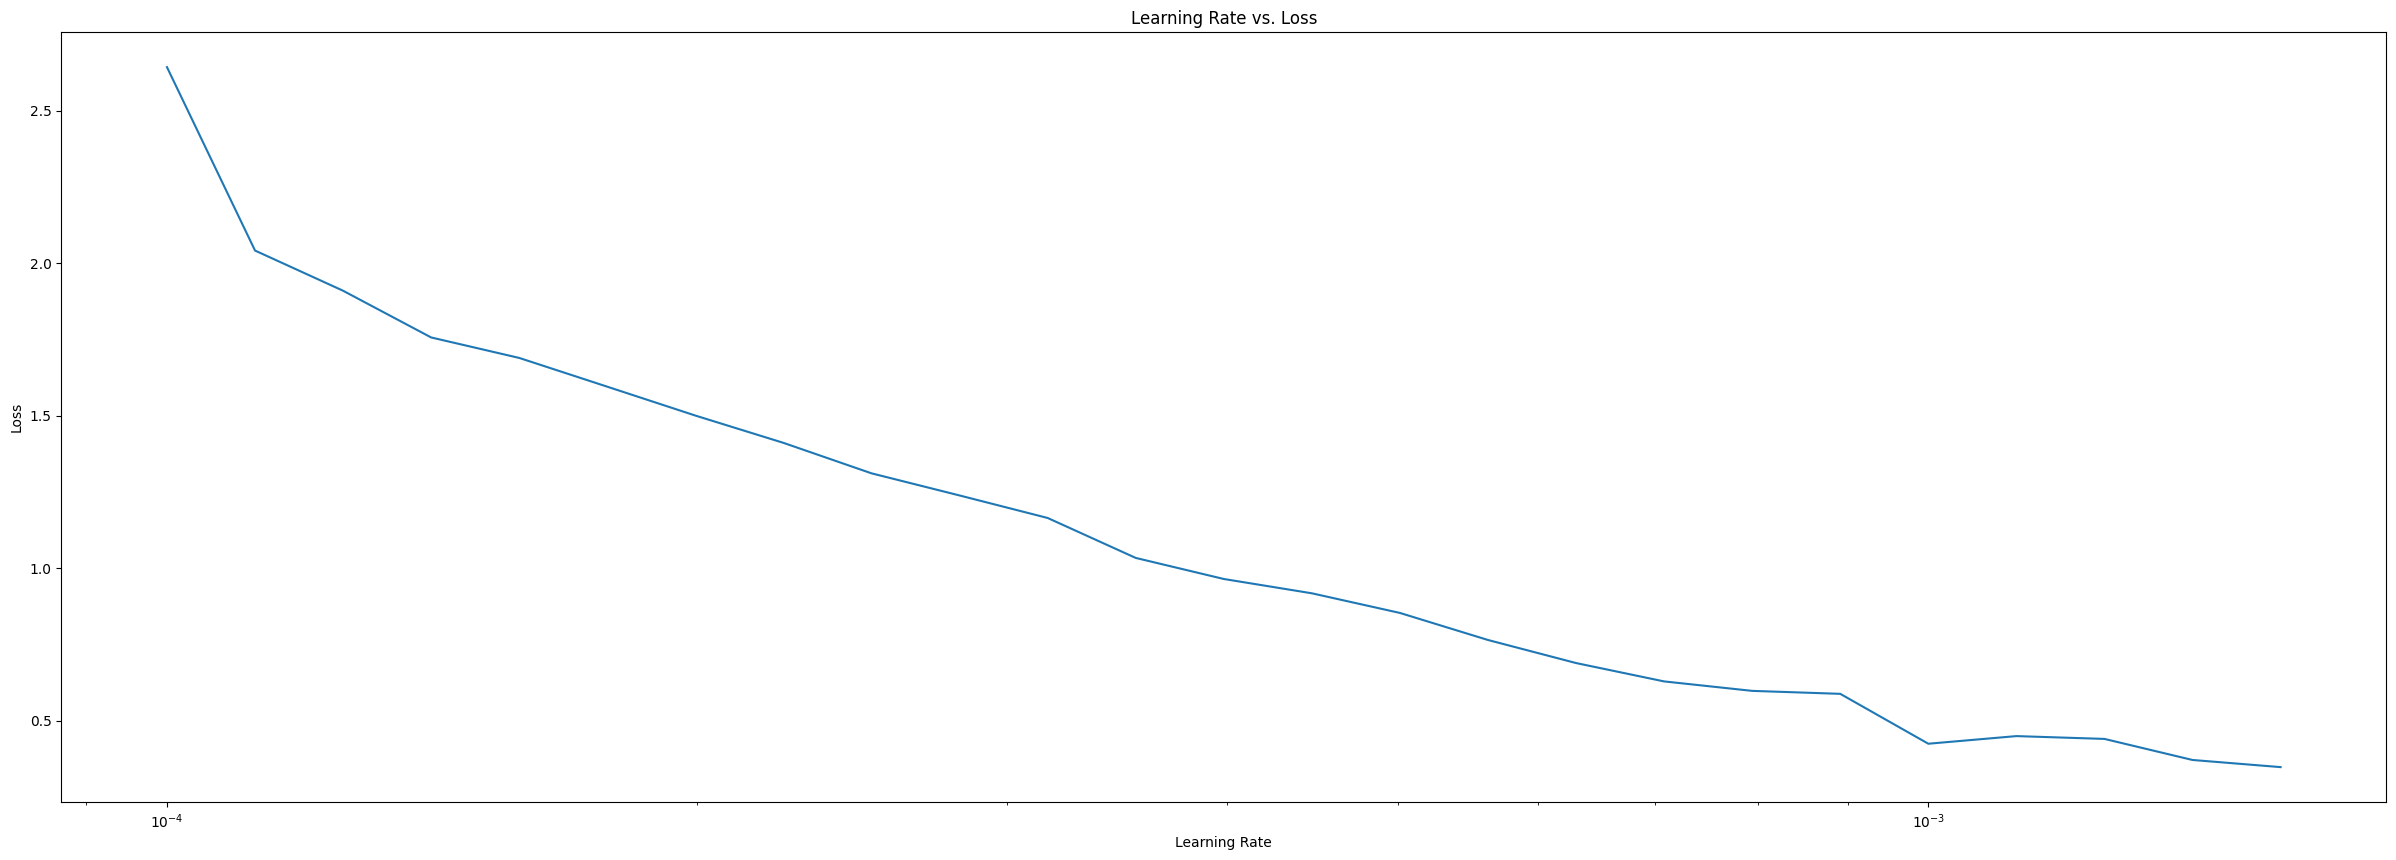

In [ ]:
lrs = 1e-4 * (10 ** (tf.range(25)/20))
plt.figure(figsize=(30, 10))
plt.semilogx(lrs, history_lr.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")

In [ ]:
# Get the loss values from the training history
losses = np.array(history_lr.history['loss'])

# Find the index of the minimum loss (after it starts decreasing)
min_loss_idx = np.argmin(losses)

# Find the corresponding learning rate
optimal_lr = lrs[min_loss_idx]

print(f"Optimal learning rate: {optimal_lr}")


Optimal learning rate: 0.0015848931924611134


$ 10^{-3} $ or 0.001 is around the best learning rate

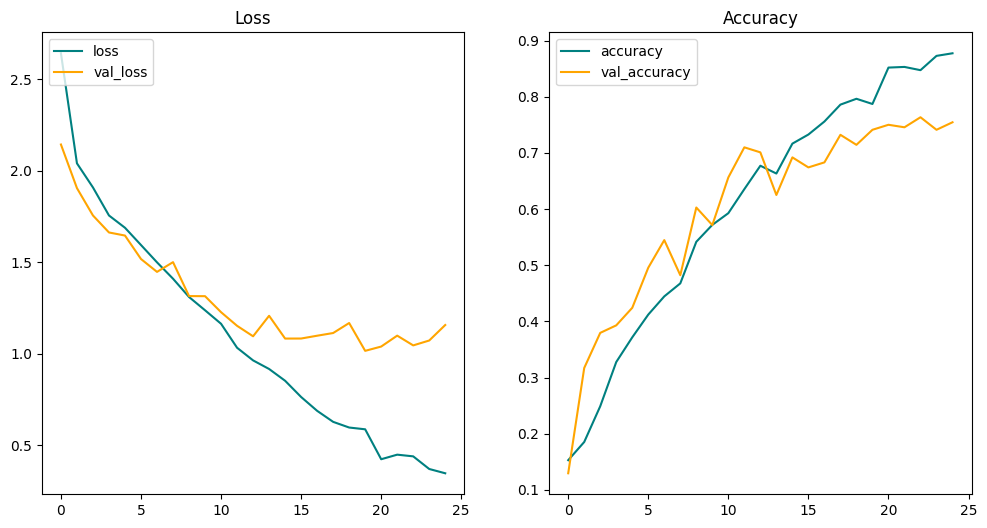

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot loss on the first subplot
ax1.plot(history_lr.history['loss'], color='teal', label='loss')
ax1.plot(history_lr.history['val_loss'], color='orange', label='val_loss')
ax1.set_title('Loss')  # Set title for the first subplot
ax1.legend(loc='upper left')  # Add a legend

# Plot accuracy on the second subplot
ax2.plot(history_lr.history['accuracy'], color='teal', label='accuracy')
ax2.plot(history_lr.history['val_accuracy'], color='orange', label='val_accuracy')
ax2.set_title('Accuracy')  # Set title for the second subplot
ax2.legend(loc='upper left')  # Add a legend

# Show all plots
plt.show()  # Display the plots

## Make Predictions with Model

In [ ]:
# Prediction Probabilities
y_prob = model_2.predict(X_test) 
y_prob[1]

7/7 [==============================] - 4s 666ms/step


array([7.84699456e-04, 1.76032318e-03, 5.83215579e-02, 1.52093230e-03,
       9.21092629e-01, 1.77556911e-04, 1.63406432e-02, 2.70244698e-07,
       4.03040907e-08, 1.13743475e-07, 1.58009684e-07, 2.54534314e-08,
       6.19471479e-08, 4.83223346e-07, 4.60484529e-07, 5.53858159e-09],
      dtype=float32)

In [ ]:

score = 0
for i in range(len(y_test)): 
    if label_names[tf.argmax(y_prob[i])] == y_test[i]: 
        
        #print(f"pred is {label_names[tf.argmax(y_prob[i])]}, actuall is {y_test[i]}")

        score +=1
    
       # print("wrong")

print(f"final score is {score/len(y_test)}")

final score is 0.7544642857142857


In [ ]:
# Get the actual label name our model predicted
label_names[tf.argmax(y_prob[4])]

4

In [ ]:
# Get the actual number from test label
y_test[4]

4

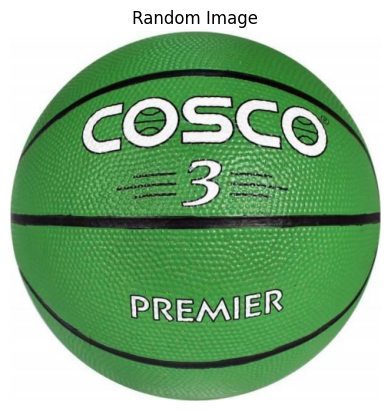

"\nimg = cv2.imread('two.jpeg')\nplt.imshow(img)\nplt.show()\n"

In [ ]:
# Initialize an empty list to store the actual labels
import cv2

image_dir = "test/basketball"

# Get list of image filenames
image_files = os.listdir(image_dir)

# Pick a random image file
random_image_file = random.choice(image_files)

# Load the random image
img = cv2.imread(os.path.join(image_dir, random_image_file))
#plt.imshow(img.numpy().astype(int))
# Display the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Random Image")
plt.axis('off')
plt.show()

"""
img = cv2.imread('two.jpeg')
plt.imshow(img)
plt.show()
"""

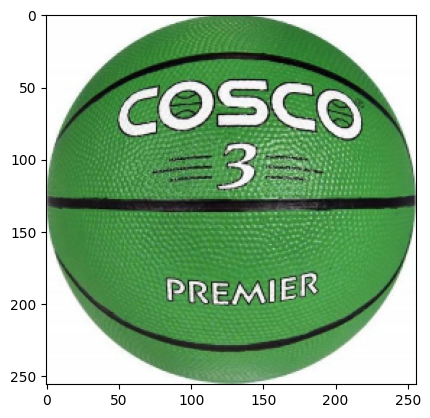

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
model_pred = model_2.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 212ms/step


In [ ]:
model_pred

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 5.8870508e-29,
        1.6592458e-37, 0.0000000e+00, 1.4804109e-28, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)